到目前为止，我们主要关注如何更新权重向量的优化算法，而不是它们的更新速率。 

然而，调整学习率通常与实际算法同样重要，有如下几方面需要考虑：

首先，学习率的大小很重要。如果它太大，优化就会发散；如果它太小，训练就会需要过长时间，或者我们最终只能得到次优的结果。我们之前看到问题的条件数很重要（有关详细信息，请参见 11.6节）。直观地说，这是最不敏感与最敏感方向的变化量的比率。

其次，衰减速率同样很重要。如果学习率持续过高，我们可能最终会在最小值附近弹跳，从而无法达到最优解。 11.5节比较详细地讨论了这一点，在 11.4节中我们则分析了性能保证。简而言之，我们希望速率衰减，但要比 $\mathcal{O}(t^{-\frac{1}{2}})$ 慢，这样能成为解决凸问题的不错选择。

另一个同样重要的方面是初始化。这既涉及参数最初的设置方式（详情请参阅 4.8节），又关系到它们最初的演变方式。这被戏称为预热（warmup），即我们最初开始向着解决方案迈进的速度有多快。一开始的大步可能没有好处，特别是因为最初的参数集是随机的。最初的更新方向可能也是毫无意义的。

最后，还有许多优化变体可以执行周期性学习率调整。这超出了本章的范围，我们建议读者阅读 (Izmailov et al., 2018)来了解个中细节。例如，如何通过对整个路径参数求平均值来获得更好的解。

鉴于管理学习率需要很多细节，因此大多数深度学习框架都有自动应对这个问题的工具。 在本章中，我们将梳理不同的调度策略对准确性的影响，并展示如何通过学习率调度器（learning rate scheduler）来有效管理。

控制收敛速度与稳定性：<br>
- 在训练初期使用较大的学习率可以加速收敛；到了后期，降低学习率能使得参数更新更加细致，从而在靠近最优解附近防止震荡和过拟合。<br>
- 动态调整学习率可以在训练中获得更平滑、更稳定的收敛过程。<br>
    
应对不同问题的需求：<br>
- 不同任务、不同网络结构可能对学习率敏感度不同。调度器提供了一种系统化的方法，使得学习率随着迭代数的增加而逐步衰减，从而兼顾初期的快速进展与后期的稳健收敛。

自动化与实验调整：<br>
- 由于调整学习率的过程通常需要尝试不同的衰减策略（例如多项式衰减，指数衰减，余弦衰减等），调度器可以使这一过程自动化，大大简化了实验调参的工作

从一个简单的问题开始，这个问题可以轻松计算，但足以说明要义。 为此，我们选择了一个稍微现代化的LeNet版本（激活函数使用relu而不是sigmoid，汇聚层使用最大汇聚层而不是平均汇聚层），并应用于Fashion-MNIST数据集。 此外，我们混合网络以提高性能。 

In [15]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.optim import lr_scheduler
from d2l import torch as d2l


def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

    return model

loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 代码几乎与d2l.train_ch6定义在卷积神经网络一章LeNet一节中的相同
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
          scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss,train_acc,num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

        # 判断是否存在调度器对象，如果存在调度器，并且不是内置的调度器，则遍历优化器的每个参数组，进行更新
        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # UsingPyTorchIn-Builtscheduler
                scheduler.step()
            else:
                # Usingcustomdefinedscheduler
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

看看如果使用默认设置，调用此算法会发生什么。 例如设学习率为0.3并训练30次迭代。 留意在超过了某点、测试准确度方面的进展停滞时，训练准确度将如何继续提高。 两条曲线之间的间隙表示过拟合

train loss 0.121, train acc 0.953, test acc 0.880


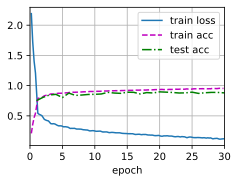

In [16]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

我们可以在每个迭代轮数（甚至在每个小批量）之后向下调整学习率。 例如，以动态的方式来响应优化的进展情况

In [17]:
lr = 0.1
trainer.param_groups[0]["lr"] = lr
print(f'learning rate is now {trainer.param_groups[0]["lr"]:.2f}')

learning rate is now 0.10


更通常而言，我们应该定义一个调度器。 当调用更新次数时，它将返回学习率的适当值

In [18]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

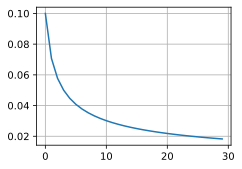

In [19]:
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

看看这对在Fashion-MNIST数据集上的训练有何影响。 我们只是提供调度器作为训练算法的额外参数

train loss 0.287, train acc 0.896, test acc 0.877


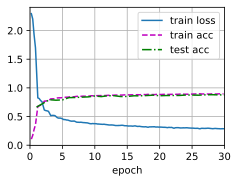

In [20]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

曲线比以前更加平滑，并且过拟合更小

单因子调度器

多项式衰减的一种替代方案是乘法衰减，即 $\eta_{t+1} \leftarrow \eta_t \cdot \alpha$ 其中 $\alpha \in (0, 1)$ 。为了防止学习率衰减到一个合理的下界之下，更新方程经常修改为 $\eta_{t+1} \leftarrow \max(\eta_{\text{min}}, \eta_t \cdot \alpha)$ 。

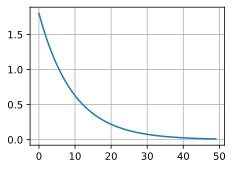

In [21]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

多因子调度器

训练深度网络的常见策略之一是保持学习率为一组分段的常量，并且不时地按给定的参数对学习率做乘法衰减。具体地说，给定一组降低学习率的时间点，例如 $s = \{5, 10, 20\}$ ，每当 $t \in s$ 时，降低 $\eta_{t+1} \leftarrow \eta_t \cdot \alpha$ 。假设每步中的值减半，我们可以按如下方式实现这一点。

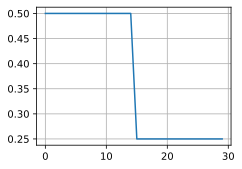

In [22]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr

d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler)
                                  for t in range(num_epochs)])

这种分段恒定学习率调度背后的直觉是，让优化持续进行，直到权重向量的分布达到一个驻点。 此时，我们才将学习率降低，以获得更高质量的代理来达到一个良好的局部最小值。 下面的例子展示了如何使用这种方法产生更好的解决方案。

train loss 0.190, train acc 0.928, test acc 0.895


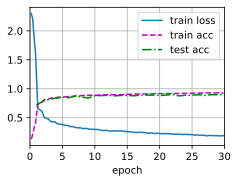

In [23]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

余弦调度器

余弦调度器是 (Loschilov and Hutter, 2016) 提出的一种启发式算法。它所依据的观点是：我们可能不想在一开始就太大地降低学习率，而且可能希望最终能用非常小的学习率来“改进”解决方案。这产生了一个类似于余弦的调度，函数形式如下所示，学习率的值在 $t \in [0, T]$ 之间。

$$\eta_t = \eta_T + \frac{\eta_0 - \eta_T}{2} (1 + \cos(\pi t / T))$$

这里 $\eta_0$ 是初始学习率， $\eta_T$ 是 T 时的目标学习率。此外，对于 t > T ，我们只需将值固定到 $\eta_T$ 而不再增加它。在下面的示例中，我们设置了最大更新步数 T = 20 。

平滑衰减：<br>
利用余弦函数可以使学习率以一个平滑、非线性的方式从初始值降低到目标值，不会出现突变，这有助于在训练末期减缓更新步长，实现更细致的参数调整

预热机制：<br>
在训练初期，由于参数初始化较随机，过大的学习率可能导致不稳定性。因此，预热阶段允许学习率从较低值逐步上升到设定值，从而稳定模型训练

目的是在训练过程中允许大步更新以迅速接近较优区域，然后再以更低的学习率在局部进行搜索，达到更好的收敛效果。<br>
同时，平滑衰减也有助于防止最后阶段在震荡区域内过度更新。

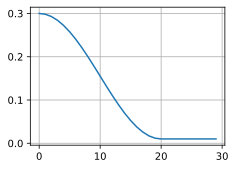

In [24]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    # 如果当前 epoch 小于预热步数，则采用线性递增的方式让学习率逐步升至初始设定值
    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)

        # 使用余弦函数计算当前学习率
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
            # math.cos(math.pi * (epoch - self.warmup_steps) / self.max_steps) 随着 epoch 从 0 变化到 max_steps，其值从 cos(0)=1 变化到 cos(π)= -1
            # 通过 (1 + cos(...))/2 则将其归一化到 [0, 1] 区间

            # 最终学习率就是在初始学习率和最终学习率之间按余弦平滑地过渡
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

在计算机视觉的背景下，这个调度方式可能产生改进的结果。 但请注意，如下所示，这种改进并不一定成立

train loss 0.193, train acc 0.929, test acc 0.900


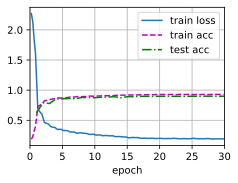

In [25]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

在某些情况下，初始化参数不足以得到良好的解。 这对某些高级网络设计来说尤其棘手，可能导致不稳定的优化结果。 对此，一方面，我们可以选择一个足够小的学习率， 从而防止一开始发散，然而这样进展太缓慢。 另一方面，较高的学习率最初就会导致发散。

解决这种困境的一个相当简单的解决方法是使用预热期，在此期间学习率将增加至初始最大值，然后冷却直到优化过程结束。 为了简单起见，通常使用线性递增。 这引出了如下表所示的时间表

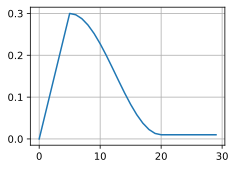

In [26]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

注意，观察前5个迭代轮数的性能，网络最初收敛得更好

train loss 0.201, train acc 0.925, test acc 0.901


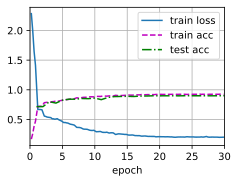

In [27]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

预热阶段限制了非常深的网络中参数的发散程度 。 这在直觉上是有道理的：在网络中那些一开始花费最多时间取得进展的部分，随机初始化会产生巨大的发散

在训练期间逐步降低学习率可以提高准确性，并且减少模型的过拟合。

在实验中，每当进展趋于稳定时就降低学习率，这是很有效的。从本质上说，这可以确保我们有效地收敛到一个适当的解，也只有这样才能通过降低学习率来减小参数的固有方差。

余弦调度器在某些计算机视觉问题中很受欢迎。

优化之前的预热期可以防止发散。

优化在深度学习中有多种用途。对于同样的训练误差而言，选择不同的优化算法和学习率调度，除了最大限度地减少训练时间，可以导致测试集上不同的泛化和过拟合量。